In [ ]:
# default_exp clock_plots

In [ ]:
#hide 

from joblib import *
from nbdev.showdoc import *
# this is used to make Federal Holidays a nonschool day.  Note that we don't have any
# way to recognize school district unique holidays, like teacher work days of such 
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np

# Making Clock Plots

> Module takes timing data processed by 'analyze_by_person' and outputs
clock plots with sleep and light information.

In order to make a clock plot, we need timing data with specific information we'd like to display on the plot. Therefore, it is recommended that the dataframes used are loaded after being processed using the **analyze_by_person** module included in the SALA library.

The sample plots here will be generated using the same example data found in the aforementioned module. Thus, we'll start by loading example parquet files written by the functions found there. Of particular interest are columns relating to light timings and sleep information.

In [ ]:
file_prefix = "example_output/"

In [ ]:
all_data = pd.read_parquet(file_prefix+'raw.parquet')
all_data.dropna().head()

,Off-Wrist Status,Activity,Marker,White Light,Red Light,Green Light,Blue Light,Sleep/Wake,Interval Status,UID,Group
DateTime,,,,,,,,,,,
2018-06-25 12:31:00,0,0.0,0.0,37.09,28.4,15.5,14.5,1.0,ACTIVE,base_v1\user1234,base_
2018-06-25 12:31:30,0,170.0,0.0,156.15,159.0,59.9,65.3,1.0,ACTIVE,base_v1\user1234,base_
2018-06-25 12:32:00,0,194.0,0.0,149.03,113.0,49.8,50.6,1.0,ACTIVE,base_v1\user1234,base_
2018-06-25 12:32:30,0,0.0,0.0,473.95,365.0,161.0,161.0,1.0,ACTIVE,base_v1\user1234,base_
2018-06-25 12:33:00,0,62.0,0.0,317.82,264.0,112.0,115.0,1.0,ACTIVE,base_v1\user1234,base_


In [ ]:
timing_data = pd.read_parquet(file_prefix+'timing.parquet', engine='fastparquet')
timing_data[
    ["Mins to LL from 4AM", "Mins to FL from 4AM",
     "Sunrise", "Sunset", "Sleep onset", "Sleep offset",
     "Sleep duration", "Sleep onset MSLM",
     "Sleep offset MSLM"]
    ].head()

,Mins to LL from 4AM,Mins to FL from 4AM,Sunrise,Sunset,Sleep onset,Sleep offset,Sleep duration,Sleep onset MSLM,Sleep offset MSLM
index,,,,,,,,,
0,1186.0,181.0,2018-06-26 05:13:10.853540-07:00,2018-06-26 21:10:56.479092-07:00,2018-06-27 00:04:30,2018-06-27 09:12:00,0 days 09:07:30,1444.5,552.0
1,1137.0,312.0,2018-06-27 05:13:37.265731-07:00,2018-06-27 21:10:53.349244-07:00,2018-06-27 23:07:30,2018-06-28 06:57:00,0 days 07:49:30,1387.5,417.0
2,1151.0,276.0,2018-07-01 05:15:45.287540-07:00,2018-07-01 21:10:14.543651-07:00,2018-07-01 20:56:30,2018-07-02 07:48:30,0 days 10:52:00,1256.5,468.5
3,1102.0,146.0,2018-07-04 05:17:43.572176-07:00,2018-07-04 21:09:17.890736-07:00,2018-07-04 22:23:00,2018-07-05 06:36:00,0 days 08:13:00,1343.0,396.0
4,1201.0,174.0,2018-07-07 05:19:59.495724-07:00,2018-07-07 21:07:57.880755-07:00,2018-07-08 00:03:30,2018-07-08 06:35:30,0 days 06:32:00,1443.5,395.5


## Mapping Minutes to Radians

It may be helpful to have the ability to take a series of minutes and turn them into radians. Although the function is primarily used as a helper in creating clock plots, it is made available in case.

In [ ]:
#export
def map_mins_to_rads(d_series):
    """Maps a series of minutes to radians for plot making.

    #### Parameters

    d_series: pd.Series
        A series of minute data

    #### Returns

    (as a tuple) list of mins converted to radians, a converted median
    """
    median = d_series.median()
    p25 = d_series.quantile(0.25)
    p75 = d_series.quantile(0.75)

    return ([x/1440.0*2*np.pi for x in np.arange(p25,p75)], median/1440.0*2*np.pi)

In [ ]:
show_doc(map_mins_to_rads, title_level = 3)

<h3 id="map_mins_to_rads" class="doc_header"><code>map_mins_to_rads</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h3>

> <code>map_mins_to_rads</code>(**`d_series`**)

Maps a series of minutes to radians for plot making.

#### Parameters

d_series: pd.Series
    A series of minute data

#### Returns

(as a tuple) list of mins converted to radians, a converted median

In [ ]:
#export
def time_print(mins: float):
    """Takes a time (minutes) and returns a printable format.

    #### Parameters

    mins: float
        A numeric value representing minutes.

    #### Returns

    A printable format
    """
    h = int(mins / 60.)
    m = int ( (mins - h * 60) )
    if h >= 24.0:
        h -= 24
    return '{:02d}:{:02d}'.format(h,m)

## Printable Time

Similarly, we provide functionality for nice time printing.

In [ ]:
show_doc(time_print, title_level = 3)

<h3 id="time_print" class="doc_header"><code>time_print</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h3>

> <code>time_print</code>(**`mins`**:`float`)

Takes a time (minutes) and returns a printable format.

#### Parameters

mins: float
    A numeric value representing minutes.

#### Returns

A printable format

## Drawing Clock Plots

The below function is responsible for actually generating the clock plots. Please ensure that the timezone given to the function as a parameter matches the timezone specified in the data. For a list of timezones please see pytz.all_timezones by importing the package pytz.

In [ ]:
#export
def make_clock_plots(timing_data,
                     group_by:str,
                     thresholds: list = [],
                     figsize: tuple = (5, 10),
                     timezone: str = None):
    """Creates clock plots for a grouping within timing data.

    #### Parameters

    timing_data: pd.DataFrame

        Timing data to use. Must be processed by the analyze_by_person package within SALA
    group_by: str

        String to subset the timing data for
    thresholds: list

        List of light thresholds.
    figsize: tuple

        Desired size of outputted figure
    timezone: str

        Timezone of participant. If None, will not draw sunrise, sunset info
    """

    sns.set_style("white")

    if not thresholds:
        thresholds = timing_data.Threshold.unique()

    g_cols = sns.color_palette("Set2", 7)
    box_rad = 0.3 / len(thresholds)
    mw = 2 * np.pi / 1440
    box_sep = 1.1

    ng = len(timing_data[group_by].unique())
    f = plt.figure(figsize = figsize)

    # gn = groupname, grp = group
    for gn, grp in enumerate(timing_data[group_by].unique()):
        ax = f.add_subplot(ng, 1, gn + 1, projection = "polar")
        tbg = timing_data[timing_data[group_by] == grp]

        # checking to see if data is all of the same timezone
        sr_tz = tbg["Sunrise"].apply(lambda x: x.tzinfo).unique()
        ss_tz = tbg["Sunrise"].apply(lambda x: x.tzinfo).unique()

        # data should be "timezone aware", as in matching the inputted timezone
        if sr_tz.size == ss_tz.size == 1 and str(sr_tz[0]) == str(ss_tz[0]) == timezone:

            # retrieving time as a float for radian conversion
            tbg["Sunrise"] = tbg["Sunrise"].apply(lambda x: x - pd.to_datetime(x.date())
                                         .tz_localize(tz=timezone)).apply(
                                          lambda x: x.total_seconds() / (60 * 60))
            tbg["Sunset"] = tbg["Sunset"].apply(lambda x: x - pd.to_datetime(x.date())
                                         .tz_localize(tz=timezone)).apply(
                                          lambda x: x.total_seconds() / (60 * 60))

            sunrise = (tbg["Sunrise"]*60).median()
            sunset = (tbg['Sunset']*60).median()
            dark = [x / 1440.0 * 2 * np.pi for x in np.arange(0, sunrise)]
            ax.bar(dark, np.ones_like(dark), width = 0.02, color = [0.42,0.42,0.42], linewidth = 0)
            dark = [x / 1440.0 * 2 * np.pi for x in np.arange(sunset, 1440)]
            ax.bar(dark, np.ones_like(dark), width = 0.02, color = [0.42, 0.42, 0.42], linewidth = 0)
        else:
            print("NOTE: Clock Plot generated without sunrise/sunset data due to timezone issues." +
                 " Please ensure entered data is timezone aware and matches expected timezone")
        lli=[]
        lll=[]
        for i, thr in enumerate(thresholds):
            added = False
            tbgt = (
                timing_data[(timing_data[group_by] == grp) & (timing_data["Threshold"] == thr)]
            )
            onset = 4 * 60 + tbgt["Mins to FL from 4AM"]
            offset = 4 * 60 + tbgt["Mins to LL from 4AM"]
            onbox, onmed = map_mins_to_rads(onset)
            offbox, offmed = map_mins_to_rads(offset)
            ll = ax.bar(onbox, np.full(len(onbox), box_rad),
                       width = mw, bottom = 1.0 - (i + 1) * box_rad * box_sep,
                       color = g_cols[i], linewidth = 0, alpha = 1.0)
            _ = ax.bar(onmed, box_rad,
                      width = 0.02, bottom = 1.0 - (i + 1) * box_rad * box_sep,
                      color = [0.2, 0.2, 0.2], linewidth = 0)

            # attempting to deal with low threshold light onset w/o offset issues
            # sometimes present in small datasets
            if (len(ll) > 0):
                lli.append(ll)
                lll.append('{:3d}lx {}-{}'.format(thr, time_print(onset.median()), time_print(offset.median())) )
                added = True
            ll = ax.bar(offbox, np.full(len(offbox), box_rad),
                       width = mw, bottom = 1.0 - (i + 1) * box_rad * box_sep,
                       color = g_cols[i], linewidth = 0, alpha = 1.0)
            _ = ax.bar(offmed, box_rad,
                    width = 0.02, bottom = 1.0 - (i + 1) * box_rad * box_sep,
                    color = [0.2, 0.2, 0.2], linewidth = 0)
            if (len(ll) > 0) and (not added):
                lli.append(ll)
                lll.append('{}lx'.format(thr))

        offset = tbgt['Sleep offset MSLM']
        onset = tbgt['Sleep onset MSLM']
        offbox, offmed = map_mins_to_rads(offset)
        onbox, onmed = map_mins_to_rads(onset)
        p = ax.bar(offbox, np.full(len(offbox), 2 * box_rad),
                  width = mw, bottom = 1.0 - (i + 3) * box_rad * box_sep,
                  color = g_cols[-2], linewidth = 0, alpha = 1.0)
        _ =ax.bar(offmed, 2 * box_rad, width = 0.02,
                  bottom = 1.0 - (i + 3) * box_rad * box_sep,
                  color=[0.2, 0.2, 0.2], linewidth=0)
        ll = ax.bar(onbox, np.full(len(onbox), 2 * box_rad),
                  width = mw, bottom = 1.0 - (i + 3) * box_rad * box_sep,
                  color = g_cols[-2], linewidth = 0, alpha = 1.0)
        _ = ax.bar(onmed, 2 * box_rad,
                  width = 0.02, bottom = 1.0 - (i + 3) * box_rad * box_sep,
                  color = [0.2, 0.2, 0.2], linewidth = 0)
        lli.append(ll)
        lll.append('Sleep {}-{}'.format(time_print(onset.median()), time_print(offset.median())) )

        thetat = np.arange(0,6)*60
        thetalbl = ['00:00','04:00','08:00','12:00','16:00','20:00']
        ax.set_thetagrids(thetat, labels=thetalbl)
        ax.set_theta_direction(-1)
        ax.set_theta_offset(np.pi)

        # less radial ticks
        ax.set_rticks([])
        ax.set_rmax(1.0)
        ax.grid(False)

        ax.legend(lli,lll,loc=[1.01,0.01],prop={'family': 'monospace'})

        nuids = len(tbg.UID.unique())
        ndays = len(tbg.Date.unique())
        pdays = len(tbgt[['UID','Date']].drop_duplicates())
        title = "{}={}: {} subjects, {} dates, {} person-days".format(group_by,grp,nuids,ndays,pdays)
        ax.set_title(title, y = 1.02) #loc='center', ha='center', va='bottom')

    plt.subplots_adjust(wspace = 1.2)

In [ ]:
show_doc(make_clock_plots, title_level = 3)

<h3 id="make_clock_plots" class="doc_header"><code>make_clock_plots</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h3>

> <code>make_clock_plots</code>(**`timing_data`**, **`group_by`**:`str`, **`thresholds`**:`list`=*`[]`*, **`figsize`**:`tuple`=*`(5, 10)`*, **`timezone`**:`str`=*`None`*)

Creates clock plots for a grouping within timing data.

#### Parameters

timing_data: pd.DataFrame

    Timing data to use. Must be processed by the analyze_by_person package within SALA
group_by: str

    String to subset the timing data for
thresholds: list

    List of light thresholds.
figsize: tuple

    Desired size of outputted figure
timezone: str

    Timezone of participant. If None, will not draw sunrise, sunset info

## Example

The example clockplot shown below groups the subject's days to compare Weekends/Holidays against business days. 

C:\Users\Tyler\AppData\Local\Temp/ipykernel_12128/1816881521.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tbg["Sunrise"] = tbg["Sunrise"].apply(lambda x: x - pd.to_datetime(x.date())
C:\Users\Tyler\AppData\Local\Temp/ipykernel_12128/1816881521.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tbg["Sunset"] = tbg["Sunset"].apply(lambda x: x - pd.to_datetime(x.date())
C:\Users\Tyler\AppData\Local\Temp/ipykernel_12128/1816881521.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy o

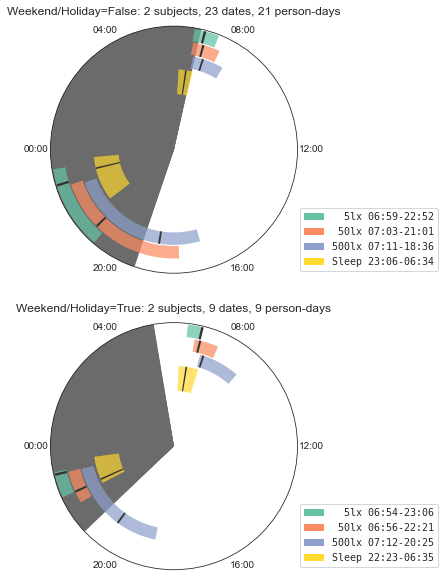

In [ ]:
make_clock_plots(timing_data, 'Weekend/Holiday', thresholds=[5, 50, 500], timezone = "America/Los_Angeles")